# Haplotype selection

In [6]:
import os
import shutil
from IPython.display import Image
import rpy2.ipython
import allel

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


get phased info (run beagle notebook if necessary)

In [14]:
%%R

library(ggplot2)
#library(tools) 
#library(svglite)
#library(fields)

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



In [11]:
%%R

def_par<-par()

chr_colors <- c("SM_V7_1"    = "cadetblue", 
                "SM_V7_2"    = "darkslategray", 
                "SM_V7_3"    = "cadetblue", 
                "SM_V7_4"    = "darkslategray", 
                "SM_V7_5"    = "cadetblue", 
                "SM_V7_6"    = "darkslategray", 
                "SM_V7_7"    = "cadetblue", 
                "SM_V7_ZW"   = "darkslategray", 
                "SM_V7_MITO" = "cadetblue")

pop_colors <- c("west_africa"   = "red",
                "east_africa"   = "yellow", 
                "new_world"     = "green")

#-------------------------------------------------------------------------------------------------
#function to get cumulative positions for manhattan style plots
#  takes in a "SM_V7?" style chromosome name and outputs the "cumulative position" of that site


#set chromosome lengths
chr_lengths <- c( "SM_V7_1"    =  88881357,
                  "SM_V7_2"    =  48130368,
                  "SM_V7_3"    =  50458499,
                  "SM_V7_4"    =  47279781,
                  "SM_V7_5"    =  25256119,
                  "SM_V7_6"    =  24989083,
                  "SM_V7_7"    =  19288021,
                  "SM_V7_ZW"   =  88385488,
                  "SM_V7_MITO" =  26917      )

#get starting (cumulative start) per chromosome
cumul_starts <- vector()
cumul_starts["SM_V7_1"]    <- 0
cumul_starts["SM_V7_2"]    <- cumul_starts["SM_V7_1"]  + chr_lengths["SM_V7_1"]
cumul_starts["SM_V7_3"]    <- cumul_starts["SM_V7_2"]  + chr_lengths["SM_V7_2"]
cumul_starts["SM_V7_4"]    <- cumul_starts["SM_V7_3"]  + chr_lengths["SM_V7_3"]
cumul_starts["SM_V7_5"]    <- cumul_starts["SM_V7_4"]  + chr_lengths["SM_V7_4"]
cumul_starts["SM_V7_6"]    <- cumul_starts["SM_V7_5"]  + chr_lengths["SM_V7_5"]
cumul_starts["SM_V7_7"]    <- cumul_starts["SM_V7_6"]  + chr_lengths["SM_V7_6"]
cumul_starts["SM_V7_ZW"]   <- cumul_starts["SM_V7_7"]  + chr_lengths["SM_V7_7"]
cumul_starts["SM_V7_MITO"] <- cumul_starts["SM_V7_ZW"] + chr_lengths["SM_V7_ZW"]

get_cumul_pos <- function(chrom, pos){
    #empty the cumul_pos vector
    cumul_pos<-vector()
    
    for(i in seq(1, length(pos))){    

        if ( chrom[i] == "SM_V7_1" ) {
               start <- cumul_starts["SM_V7_1"]
           } else if ( chrom[i] == "SM_V7_2" ) {
               start <-cumul_starts["SM_V7_2"]
           } else if ( chrom[i] == "SM_V7_3" ) {
               start <- cumul_starts["SM_V7_3"]
           } else if ( chrom[i] == "SM_V7_4" ) {
               start <- cumul_starts["SM_V7_4"]
           } else if ( chrom[i] == "SM_V7_5" ) {
               start <- cumul_starts["SM_V7_5"]
           } else if ( chrom[i] == "SM_V7_6" ) {
               start <- cumul_starts["SM_V7_6"]
           } else if ( chrom[i] == "SM_V7_7" ) {
               start <- cumul_starts["SM_V7_7"]
           } else if ( chrom[i] == "SM_V7_ZW" ) {
               start <- cumul_starts["SM_V7_ZW"]
           } else if ( chrom[i] == "SM_V7_MITO" ) {
               start <- cumul_starts["SM_V7_MITO"]
           } else {
              print("ERROR UNRECOGNIZED CHR")
           }
        #set cul position for site
        cumul_pos[i]<-pos[i] +  start
    }
    return(cumul_pos)

}

# #was trying to get a more effiecientfunction but kept having issues with starts from chrZW and mito being
# #   being switched.
# get_cumul_pos <- function(chrom, pos){
#     #empty the cumul_pos vector
#     cumul_pos<-vector()
#     test<-vector()

#     #for each position
#     for( i in seq(1, length(chrom))){
#         #print(cumul_starts)
#         #add the position plus cumulitive start
#         cumul_pos[i] <- cumul_starts[chrom[i]] + pos[i]
#         print(paste(i, chrom[i], pos[i], cumul_starts[chrom[i]], cumul_pos[i], sep=" "))
#     }
#    
#     return(cumul_pos)
#    
# }

## iHS

iHS (Integrated Haplotype Score) is a statistic that has been developed to detect evidence of recent positive selection at a locus. It is based on the differential levels of linkage disequilibrium(LD) surrounding a positively selected allele compared to the background allele at the same position. An extreme positive iHS score (iHS > 2) means that haplotypes on the ancestral allele background are longer compared to derived allele background. An extreme negative iHS score (iHS < -2) means that the haplotypes on the derived allele background are longer compared to the haplotypes associated with the ancestral allele. Under our model we expect selected derived alleles to harbour excessive LD relative to the background. However, an extreme positive iHS score is also considered as a candidate because the ancetral allele may be hitchhiking along with the selected allele, or the ancestral allele itself may be the target of selection. iHS has the highest power to detect selection when the selected allele has swept to intermediate frequencies. The power of iHS also depends on many other factors such as local SNP density, SNP ascertainment, availability of haplotype phase information and intensity of selection among others. For more detailed information on this statistic and results of a whole genome scan, please refer to our associated publication (Voight et al, 2006).

__For my purposes have taken the abs of the iHS score.__

In [ ]:
if os.path.isdir("results/ihs"):
    shutil.rmtree("results/ihs")
os.mkdir("results/ihs")

In [7]:
sample_idx={}
pop_ac={}

#check this by hand that the idxs from the beagle results match the idxs given here
sample_idx["new_world"]   = list(range(12,60))
sample_idx["east_africa"] = list(range(101,155))
sample_idx["west_africa"] = list(range(61,71)) + list(range(72,97))

In [8]:
#get idx to extract each chrom idividually
chroms = ['SM_V7_1', 'SM_V7_2', 'SM_V7_3', 'SM_V7_4',
          'SM_V7_5', 'SM_V7_6', 'SM_V7_7']

#declare lists
genome_ihs=[]
genome_pos=[]
genome_chr=[]

#declare dicts
hs={}
chrom_hs={}

#read in PHASED vcf
phased_callset=allel.read_vcf('results/phasing/auto_beagle.vcf')

#after reading in the vcf file get a idx of the chrom and pos for each variant
chrom=phased_callset['variants/CHROM']
pos=phased_callset['variants/POS']
idx=allel.ChromPosIndex(chrom, pos)

#get genotypes
phased_g=phased_callset['calldata/GT']
gt=allel.GenotypeArray(phased_g)

In [12]:
#cycle through populations to calculate ihs
pops=["west_africa", "east_africa", "new_world"]
for pop in pops:

    #go ahead and make output file with header
    with open("results/ihs/" + pop + "_ihs.csv", 'w') as ihs_file:
        out="CHROM,POS,IHS,normIHS\n"
        ihs_file.write(out)

    #get pop genotypes, allele counts, alt allele counts, and haplotypes
    pop_gt  = gt.take(sample_idx[pop], axis=1)
    pop_ac  = gt.count_alleles()
    pop_aac = pop_ac[:, 1]
    pop_h   = pop_gt.to_haplotypes()

    #working on H stat
    hs[pop]=pop_h
    chrom_hs[pop]={}
    
    #get genome_wide ihs (for normalization)
    all_ihs=[]
    all_pos=[]

    #cyle through each chrom
    for chrom in chroms:

        #get chromosome specific data
        to_slice    = idx.locate_key(chrom)
        chr_pop_h   = pop_h[to_slice] #haplotypes
        chr_pop_aac = pop_aac[to_slice]
        chrom_hs[pop]=chr_pop_h
        
        #get phy pos
        var_pos=pos[to_slice]

        unstand_ihs=allel.ihs(chr_pop_h, var_pos)
        stand_ihs=allel.standardize_by_allele_count(unstand_ihs, chr_pop_aac, n_bins=100, diagnostics=False)[0]

        #print ihs, pos, and chr to file
        i=0
        with open("results/ihs/" + pop + "_ihs.csv", 'a') as ihs_file:
            for i in range(len(unstand_ihs)):
                out="{chrom},{pos},{ihs},{sihs}\n".format(chrom = chrom, pos = var_pos[i], ihs = unstand_ihs[i], sihs=stand_ihs[i] )
                ihs_file.write(out)
                i=i+1

/master/nplatt/anaconda3/envs/sch_man_nwinvasion-nbanalyses/lib/python3.7/site-packages/allel/stats/selection.py:1258: RuntimeWarning: invalid value encountered in true_divide
  score_standardized[loc] = (score[loc] - m) / s
/master/nplatt/anaconda3/envs/sch_man_nwinvasion-nbanalyses/lib/python3.7/site-packages/allel/stats/selection.py:1258: RuntimeWarning: invalid value encountered in true_divide
  score_standardized[loc] = (score[loc] - m) / s
/master/nplatt/anaconda3/envs/sch_man_nwinvasion-nbanalyses/lib/python3.7/site-packages/allel/stats/selection.py:1258: RuntimeWarning: invalid value encountered in true_divide
  score_standardized[loc] = (score[loc] - m) / s


In [16]:
%%R
head(ihs_df)

    CHROM    POS IHS normIHS cumul_pos
1 SM_V7_1 302288 NaN     NaN    302288
2 SM_V7_1 705190 NaN     NaN    705190
3 SM_V7_1 705210 NaN     NaN    705210
4 SM_V7_1 705322 NaN     NaN    705322
5 SM_V7_1 705337 NaN     NaN    705337
6 SM_V7_1 705340 NaN     NaN    705340


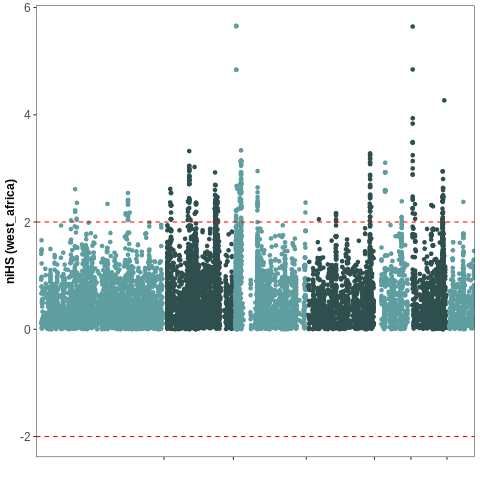

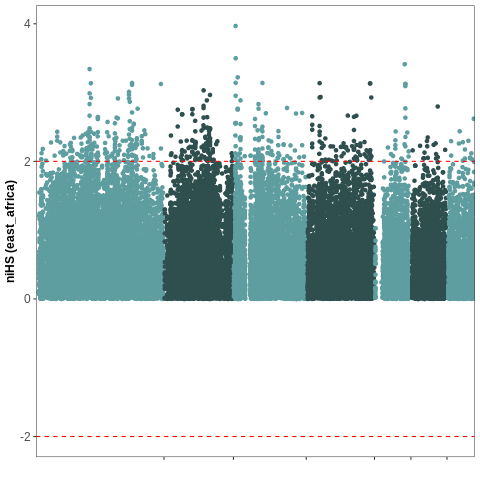

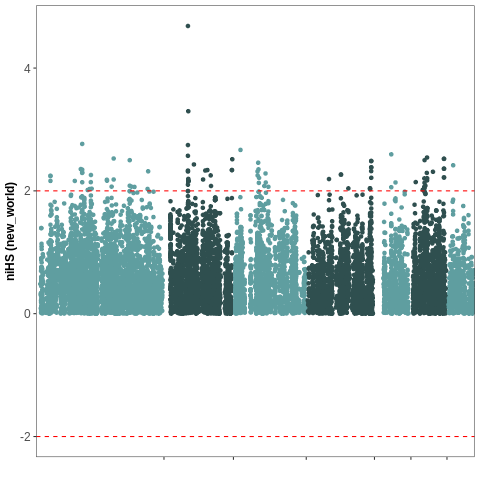

In [18]:
%%R

pops=c('west_africa', 'east_africa', 'new_world')

for (pop in pops){
    ihs_file=paste("results/ihs/", pop, "_ihs.csv", sep="")
    ihs_df<-read.csv(ihs_file, header=TRUE, sep=",")
    
    #get position for plotting
    cumul_pos<-get_cumul_pos(ihs_df$CHROM,ihs_df$POS)

   

    # #build dataframe
    ihs_df<-data.frame(ihs_df, cumul_pos)

    #start plotting
    p <- ggplot(ihs_df, 
                aes(x     = cumul_pos, 
                    y     = abs(IHS), 
                    color = CHROM))

    #adjust colors
    p <- p + scale_colour_manual(values = chr_colors)

    #plot data
    p <- p + geom_point(alpha = 1)

    # #add horizontal line at 99.5th Zscore
    p <- p + geom_hline(yintercept = 2, 
                    linetype   = "dashed",
                    color      = "red")
    p <- p + geom_hline(yintercept = -2, 
                    linetype   = "dashed", 
                    color      = "red")
#     p <- p + geom_hline(yintercept = quantile(abs(ihs_df$normIHS), 0.995, na.rm=TRUE), 
#                     linetype   = "dashed", 
#                     color      = "red")
    #modify x and y axis
    p <- p + scale_x_continuous(name   = "", 
                                breaks = cumul_starts, 
                                expand = c(0,0))
    p <- p + scale_y_continuous(name   = paste("niHS (", pop, ")", sep=""), 
                                #expand = c(0,0),
    #                             limits = c(min(ihs_df$normIHS * 1.15), 
    #                                        max(ihs_df$normIHS * 1.15)),
                                #breaks = c(-0.2, 0, 0.2, 0.4, 0.6, 0.8)
                               )

    # #change theme
    p <- p + theme_bw()

    #change fonts on axis elements and titles
    p <- p + theme(axis.text   = element_text(size = 12),
                   axis.title  = element_text(size = 12,
                                              face = "bold"),
                   axis.text.x = element_blank())

    #removing gridlines
    p <- p + theme(panel.grid.major  = element_blank(), 
                    panel.grid.minor = element_blank())

    #set up plot title etc.
    #p <- p + ggtitle(paste("niHS (", pop, ")", sep=""))
    #p <- p + theme(plot.title = element_text(hjust = 0.5, 
    #                                         vjust = 0.5, 
    #                                         face  = 'bold', 
    #                                         size  = 18))

    #modify legend
    p <- p + theme(legend.position = "none")

    #save the figure
    #svg_img <- paste("results/ihs/", pop, "_abs_normiHS.svg", sep="")
    #png_img <- paste("results/ihs/", pop, "_abs_normiHS.png", sep="")
    #svg_img <- paste("results/ihs/", pop, "_normiHS.svg", sep="")
    #png_img <- paste("results/ihs/", pop, "_normiHS.png", sep="")
    #ggsave(png_img, plot = p, dpi = 600)
    #ggsave(svg_img, plot = p)

    #display in notebook
    print(p)
    #ihs_plots<-append(ihs_plots, p)
    #ggsave(paste("results/ihs/", pop, "_normiHS_composite.png", sep=""), plot = p, width = 10, height = 1.5, units = "in", dpi = 300)

}

In [89]:
for pop in ["new_world"]:
    chroms=[]
    poss=[]
    ihss=[]
    norm_ihss=[]
    
    #read ihs_file into list (memory)
    with open("results/ihs/" + pop + "_ihs.csv", 'r') as ihs_file:
        for ihs_entry in ihs_file:
            chrom, pos, ihs, norm_ihs = ihs_entry.split(",")
            
            if ihs <= 2:
                


16226

In [102]:
ihs

'0.30549493895260216'

In [131]:
for pop in ["new_world"]:
    chroms=[]
    poss=[]
    ihss=[]
    norm_ihss=[]
    
    #read ihs_file into list (memory)

    with open("results/ihs/" + pop + "_ihs.csv", 'r') as ihs_file:
       
        next(ihs_file)
        for ihs_entry in ihs_file:
            chrom, pos, ihs, norm_ihs = ihs_entry.split(",")

            if ihs != 'nan':
                chroms.append(chrom)
                poss.append(int(pos))
                ihss.append(float(ihs))
                norm_ihss.append(float(norm_ihs.strip()))

    for i in list(range(0, len(chroms))):
#        if chroms[i] == chroms[i+1]:
        if abs(ihss[i]) >= 2:
            j=i + 1
            while abs(ihss[j]) >= 2:
                j = j+1
            
            print(str(i) + " " + str(j))
            i=j
#                     if j > 1:
#                         print("consequtive " + chroms[i] + ":" + str(poss[i]) + " " + chroms[j] + ":" + str(poss[j]))
#                     j=i
            
#             if abs(ihss[i]) >= 2 and abs(ihss[j]) >=2:
#                 #while 
#                 print("consequtive " + chroms[i] + ":" + str(poss[i]) + " " + chroms[j] + ":" + str(poss[j]))
#                 #find the next significant
#                 j=2
#                 while ihss[j] >= 2:
#                     j=j+1
                    
#                     print(str(i) + " " + str(j))

304 306
305 306
307 308
1296 1297
1556 1557
1606 1607
1609 1610
1611 1612
1613 1615
1614 1615
1874 1875
1942 1943
1999 2000
2018 2019
2054 2055
2649 2650
2669 2670
2954 2955
3041 3042
3045 3046
3686 3688
3687 3688
3758 3759
3856 3857
4391 4392
4415 4416
5669 5672
5670 5672
5671 5672
5674 5677
5675 5677
5676 5677
5712 5720
5713 5720
5714 5720
5715 5720
5716 5720
5717 5720
5718 5720
5719 5720
5995 5996
6361 6362
6458 6459
6581 6582
6748 6749
6768 6769
7615 7618
7616 7618
7617 7618
8072 8073
8522 8523
8588 8589
8609 8610
8622 8623
8669 8670
8692 8693
8927 8928
8971 8972
8990 8991
9076 9077
10872 10873
11136 11138
11137 11138
11531 11532
12344 12345
12346 12347
12408 12409
12548 12549
12563 12567
12564 12567
12565 12567
12566 12567
12577 12578
12865 12866
12877 12878
13038 13039
13686 13687
13866 13867
13929 13932
13930 13932
13931 13932
13934 13935
13950 13951
13963 13964
14000 14001
14042 14043
14062 14063
14068 14069
14070 14071
14325 14326
15418 15422
15419 15422
15420 15422
15421 1542

## Garunds H

In [ ]:
#allel.garud_h(h)
if os.path.isdir("results/garud_h"):
    shutil.rmtree("results/garud_h")
os.mkdir("results/garud_h")

#print formated header to jupyter dev.
dash = '-' * 68
print(dash)
print('{:<12}{:>14s}{:>14s}{:>14s}{:>14s}'.format("Population", "H1", "H12", "H123", "H2/H1"))
print(dash)

#write header to file
with open("results/garud_h/garud_h.csv", 'a') as h_file:
    header='{},{},{},{},{}\n'.format("POP", "H1", "H12", "H123", "H2/H1")
    h_file.write(header)

#calculate H for each population
#  print to csv
#  and to stdout
for pop in hs.keys():
    h1, h12, h123, h2_h1 = allel.garud_h(hs[pop])
    h_csv="{pop},{h1},{h12},{h123},{h2_h1}\n".format(pop   = pop,
                                                     h1    = h1,
                                                     h12   = h12,
                                                     h123  = h123,
                                                     h2_h1 = h2_h1)
    with open("results/garud_h/garud_h.csv", 'a') as h_file:
        h_file.write(h_csv)

    print('{pop:<12s}{h1:14f}{h12:14f}{h123:14f}{h2_h1:14f}'.format(pop   = pop,
                                                                    h1    = h1,
                                                                    h12   = h12,
                                                                    h123  = h123,
                                                                    h2_h1 = h2_h1))

## xpehh

In [ ]:
if os.path.isdir("results/xpehh"):
    shutil.rmtree("results/xpehh")
os.mkdir("results/xpehh")

In [ ]:
genome_ihs=[]
genome_pos=[]
genome_chr=[]

hs={}
chrom_hs={}
chrom_pos={}

#read in vcf
phased_callset=allel.read_vcf('results/phasing/schMan_v7_exome_phased.vcf')

chrom=phased_callset['variants/CHROM']
pos=phased_callset['variants/POS']
idx=allel.ChromPosIndex(chrom, pos)

#get genotypes
phased_g=phased_callset['calldata/GT']
gt=allel.GenotypeArray(phased_g)

In [ ]:
#cycle through populations
pops = ['west_africa', 'east_africa', 'new_world']
for pop in pops:

#     #go ahead and make output file with header
#     with open("results/ihs/" + pop + "_ihs.csv", 'w') as ihs_file:
#         out="CHROM,POS,IHS,normIHS\n"
#         ihs_file.write(out)

    #get pop genotypes, allele counts, alt allele counts, and haplotypes
    pop_gt  = gt.take(sample_idx[pop], axis=1)
    pop_ac  = gt.count_alleles()
    pop_h   = pop_gt.to_haplotypes()

    #working on H stat
    hs[pop]=pop_h
    chrom_hs[pop]={}
    
    for chrom in chroms:

        #get chromosome specific data
        to_slice             = idx.locate_key(chrom)
        chr_pop_h            = pop_h[to_slice] #haplotypes
        chrom_hs[pop][chrom] = chr_pop_h
        chrom_pos[chrom]     = pos[to_slice]

Calculate xpehh from the previously stored haplotype arrays.  prints to csv file that can be imported/plotted in R

In [ ]:
#list of population comparisons for xpehh
xpehh_comparison=[["brazil",  "niger"     ],
                  ["brazil",  "senegal"  ],
                  ["brazil",  "tanzania"  ],
                  ["brazil",  "wafrica"   ],
                  ["brazil",  "africa"    ],
                  ["wafrica", "tanzania" ]]


#designate csv headerline
header = '{},{},{},{}\n'.format("CHROM", "POS", "XPEHH", "SXPEHH")
    
#make comparisons between population
for pops in xpehh_comparison:
    pop1 = pops[0]
    pop2 = pops[1]
    
    #define the outfile and print headerline
    outfile = "results/xpehh/" + pop1 + "_" + pop2 + "_xpehh.csv"
    with open(outfile, 'w') as xpehh_file:
        xpehh_file.write(header)
    
    #reset all lists
    genome_xpehh  = []
    genome_sxpehh = []
    genome_pos    = []
    genome_chr    = []
 
    #calculate xpehh(s) for each chrom.
    for chr in chroms:
    
        #xpehh
        xpehh=allel.xpehh(chrom_hs[pop1][chr], 
                          chrom_hs[pop2][chr], 
                          chrom_pos[chr], 
                          min_ehh=0.05)
        
        #standardize
        sxpehh=allel.standardize(xpehh)
        
        #add values to others per pop comparison
        genome_xpehh.extend(xpehh)
        genome_sxpehh.extend(sxpehh)
        genome_pos.extend(chrom_pos[chr])
       
        
        #print values to csv outfile
        with open(outfile, 'a') as xpehh_file:
            for i in range(len(xpehh)):
                out_line = '{},{},{},{}\n'.format(chr, 
                                                  chrom_pos[chr][i], 
                                                  xpehh[i], 
                                                  sxpehh[i])
                xpehh_file.write(out_line)

In [ ]:
%%R

#define pops in each comparison
pop1s <- c("brazil", "brazil",   "brazil",   "brazil",  "wafrica"  )
pop2s <- c("niger",  "tanzania", "wafrica",  "africa",  "tanzania" )

#iterate through the comparisons
j<-1
while (j <= length(pop1s)){

    #define pops in comparison
    pop1<-pop1s[j]
    pop2<-pop2s[j]

    #open and read xpehh infile
    xpehh_infile  <-paste("results/xpehh/", pop1, "_", pop2,"_xpehh.csv", sep="")
    xpehh<-read.csv(xpehh_infile, sep=",", header=TRUE)

    #get cumulative positions for plotting
    cumul_pos<-get_cumul_pos(xpehh$CHROM,xpehh$POS)


    #build dataframe
    xpehh<-data.frame(xpehh, cumul_pos)

    #start plotting
    p <- ggplot(xpehh, 
                aes(x     = cumul_pos, 
                    y     = SXPEHH, 
                    color = CHROM))

    #adjust colors
    p <- p + scale_colour_manual(values = chr_colors)

    #plot data
    p <- p + geom_point()

    #add horizontal line at 99.5th Zscore
    p <- p + geom_hline(yintercept = quantile(xpehh$SXPEHH, 0.995, na.rm=TRUE), 
                    linetype   = "dashed",
                    color      = "red")
    p <- p + geom_hline(yintercept = quantile(xpehh$SXPEHH, 0.005, na.rm=TRUE), 
                    linetype   = "dashed", 
                    color      = "red")

    #modify x and y axis
    p <- p + scale_x_continuous(name   = "", 
                                breaks = cumul_starts, 
                                expand = c(0,0))
    p <- p + scale_y_continuous(name   = "nxpEHH")

    # #change theme
    p <- p + theme_bw()

    #change fonts on axis elements and titles
    p <- p + theme(axis.text   = element_text(size = 12),
                   axis.title  = element_text(size = 12,
                                              face = "bold"),
                   axis.text.x = element_blank())

    #removing gridlines
    p <- p + theme(panel.grid.major  = element_blank(), 
                    panel.grid.minor = element_blank())

    #set up plot title etc.
    p <- p + ggtitle(paste("standardized xpEHH (", pop1, " v ", pop2, ")", sep=""))
    p <- p + theme(plot.title = element_text(hjust = 0.5, 
                                             vjust = 0.5, 
                                             face  = 'bold', 
                                             size  = 12))

    #modify legend
    p <- p + theme(legend.position = "none")

    #save the figure
    svg_img <- paste("results/xpehh/", pop1, "_", pop2,"_xpehh.svg", sep="")
    png_img <- paste("results/xpehh/", pop1, "_", pop2,"_xpehh.png", sep="")
    ggsave(png_img, plot = p, dpi = 600)
    ggsave(svg_img, plot = p)
    ggsave(paste("results/xpehh/", pop1, "_", pop2,"_xpehh.COMPOSITE.png", sep=""),
           plot = p, 
           dpi = 600,
           width = 10, 
           height = 1.5, 
           units = "in", 
          )
    #display in notebook
    print(p)
    #ihs_plots<-append(ihs_plots, p)
    
    j<-j+1
}

In [ ]:
%%R


# xpehh_infile  <-paste("results/xpehh/brazil_africa_xpehh.csv", sep="")
# xpehh<-read.csv(xpehh_infile, sep=",", header=TRUE)

#  xpehh<-xpehh[complete.cases(xpehh), ]

        #smooth
smoothed_med<-runmed(x = xpehh$SXPEHH, k = 201, endrule="median")

# runmed(xpehh$SXPEHH, 21)
plot(smoothed_med, pch=19, col=alpha("black", 1))
abline(h=quantile(xpehh$SXPEHH, 0.995, na.rm=TRUE), col="red")
abline(h=quantile(xpehh$SXPEHH, 0.005, na.rm=TRUE), col="red")